В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

#### Імпорти

In [137]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

In [138]:
data_dir = '../../../data/bank-customer-churn-prediction-dlu'

In [139]:
os.listdir(data_dir)

['sample_submission.csv',
 'submissions',
 'submission_log_reg.csv',
 'test.csv',
 'train.csv',
 'transformed']

In [140]:
train_dir = '../../../data/bank-customer-churn-prediction-dlu/train.csv'
test_dir = '../../../data/bank-customer-churn-prediction-dlu/test.csv'


In [141]:
train_val_df = pd.read_csv(train_dir)
train_val_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [142]:
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['Exited'])
# train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)


In [143]:
train_df['Exited'].value_counts()

Exited
0.0    9558
1.0    2442
Name: count, dtype: int64

In [144]:
val_df['Exited'].value_counts()


Exited
0.0    2390
1.0     610
Name: count, dtype: int64

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [145]:
input_cols = train_df.columns[1:-1].tolist()
target_col = train_df.columns[-1]


In [146]:
input_cols, target_col


(['CustomerId',
  'Surname',
  'CreditScore',
  'Geography',
  'Gender',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 'Exited')

In [147]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

In [148]:
train_inputs.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7180,15652218.0,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24
10393,15592937.0,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31
80,15774586.0,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01
3365,15780572.0,K?,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98
12236,15642099.0,Trevisani,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76


In [149]:
train_targets.head()

7180     0.0
10393    0.0
80       0.0
3365     0.0
12236    0.0
Name: Exited, dtype: float64

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [150]:
numeric_cols = train_inputs.select_dtypes(exclude='object').columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

In [151]:
numeric_cols, categorical_cols

(['CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [152]:
train_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 7180 to 9360
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       12000 non-null  float64
 1   Surname          12000 non-null  object 
 2   CreditScore      12000 non-null  float64
 3   Geography        12000 non-null  object 
 4   Gender           12000 non-null  object 
 5   Age              12000 non-null  float64
 6   Tenure           12000 non-null  float64
 7   Balance          12000 non-null  float64
 8   NumOfProducts    12000 non-null  float64
 9   HasCrCard        12000 non-null  float64
 10  IsActiveMember   12000 non-null  float64
 11  EstimatedSalary  12000 non-null  float64
dtypes: float64(9), object(3)
memory usage: 1.2+ MB


In [153]:
train_val_df.isnull().sum()


id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Датасет не має пропущених значень. 



#### Обробка категоріальних змінних
Подивимось скільки унікальних значень має кожна колонка

In [154]:

train_inputs[categorical_cols].nunique()

Surname      732
Geography      3
Gender         2
dtype: int64

In [155]:
train_inputs['Geography'].unique()

array(['France', 'Germany', 'Spain'], dtype=object)

In [156]:
train_inputs['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [157]:
train_inputs['Surname'].unique()[:100]


array(['Mays', "Ch'eng", "Ch'in", 'K?', 'Trevisani', 'Mazzi', 'Fanucci',
       "Ch'ang", 'Pritchard', "T'ien", 'Hsiung', 'Chin', "Ch'ien",
       'Uchechukwu', 'Yudina', 'Pugh', "T'ang", 'Nwankwo', 'Lombardi',
       'Cremonesi', "K'ung", 'Horsley', 'Goliwe', 'Brient', 'Ugochukwu',
       'Chukwumaobim', 'Lueck', 'Chiu', 'Toscani', 'Onuoha', 'Ting',
       'Echezonachukwu', 'Zetticci', 'Nnanna', 'Oluchukwu', 'Tuan',
       'Hsiao', 'Nworie', 'Chiang', 'Pirozzi', 'Ngozichukwuka', 'Frolov',
       'Y?an', "Ts'ao", 'Nwachukwu', 'Maclean', "Ts'ai", 'Folliero', 'Y?',
       'Onyemauchechukwu', 'Nkemakolam', 'Ku', 'Smith', 'Yobachi',
       'Milano', 'Fiorentino', 'Hsing', 'H?', 'Shih', 'Chien', 'Ijendu',
       'Yobanna', "Ch'iu", 'Eluemuno', 'Tsou', 'Chinwemma', 'Pinto',
       'Harker', 'Chukwukadibia', 'Rizzo', 'Ejimofor', 'Ugoji', 'Hsia',
       'Nnaife', 'Kao', 'Lombardo', 'Nweke', 'Clements', 'Chukwubuikem',
       'Ives', 'Zito', 'Teng', 'Chikelu', 'Tsao', 'Lettiere',
       'Napoli

Колонки `Geography` та `Gender` мають 3 та 2 унікальних значень відповідно, закодуємо спочатку їх використовуючи OneHot кодування

In [158]:
from sklearn.preprocessing import OneHotEncoder

# тренуємо енкодер на тренувальних даних
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc.fit(train_inputs[['Geography', 'Gender']])
# enc.fit(train_inputs[categorical_cols])


enc.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [159]:
encoded_cols = enc.get_feature_names_out(['Geography', 'Gender'])
# encoded_cols = enc.get_feature_names_out(categorical_cols)

encoded_cols

array(['Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male'], dtype=object)

In [160]:
# Додаємо закодовані колонки до даних
train_inputs[encoded_cols] = enc.transform(train_inputs[['Geography', 'Gender']])
val_inputs[encoded_cols] = enc.transform(val_inputs[['Geography', 'Gender']])

# train_inputs[encoded_cols] = enc.transform(train_inputs[categorical_cols])
# val_inputs[encoded_cols] = enc.transform(val_inputs[categorical_cols])



У колонці `Gender` є лише 2 унікальних значення, `Male` та `Female`. Подивимось яке з них зустрічається частіше 

In [161]:
train_inputs[['Gender_Female', 'Gender_Male', 'Gender']].value_counts()

Gender_Female  Gender_Male  Gender
0.0            1.0          Male      6876
1.0            0.0          Female    5124
Name: count, dtype: int64

Так як унікальних значень всього 2, можна видалити одну з колонок створених енкодером для ствпця `Gender`, щоб уикнути мультиколінеарності.
Чоловіків у даних більше, тож щоб значення Male було закодовано 1, видалимо колонку `Gender_Female`

In [162]:
train_inputs = train_inputs.drop(['Gender_Female'], axis=1)
val_inputs = val_inputs.drop(['Gender_Female'], axis=1)

# train_inputs = train_inputs.drop(['Geography_France'], axis=1)
# val_inputs = val_inputs.drop(['Geography_France'], axis=1)



Колонка `Surname` має 720 унікальних значень, що забагато для простого кодування. Так як прізвище людини не є дуже інформативною ознакою почнемо з побудови найпростішої моделі і не будемо використовувати цю колонку для навчання

In [163]:
# train_inputs = train_inputs.drop(['Surname'], axis=1)
# val_inputs = val_inputs.drop(['Surname'], axis=1)

Перевіримо що всі закодовані колонки коректно додались до датафрейму

In [164]:
train_inputs.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,15652218.0,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,1.0,0.0,0.0,1.0
10393,15592937.0,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,1.0,0.0,0.0,0.0
80,15774586.0,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0,1.0,0.0,1.0
3365,15780572.0,K?,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98,0.0,0.0,1.0,1.0
12236,15642099.0,Trevisani,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76,1.0,0.0,0.0,1.0


#### Обробка числових змінних

In [165]:
train_df[numeric_cols].describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,1.569092e+07,658.840250,37.687917,5.026083,43008.174362,1.590250,0.790333,0.491583,117992.400015
std,1.469310e+05,72.334909,8.138440,2.781974,59906.627660,0.532646,0.407088,0.499950,45589.484607
min,1.581102e+06,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,1.563512e+07,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83343.730000
50%,1.568995e+07,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123613.910000
75%,1.575692e+07,708.000000,42.000000,7.000000,109949.050000,2.000000,1.000000,1.000000,156912.810000
max,1.581569e+07,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000


Числові стовпці в даних мають різні діапазони, тому, щоб конкретні ознаки не мали непропорційного впливу на втрати моделі, застосуємо до даниих масштабування використавши `MinMaxScaler` привевши дані до діапазону від 0 до 1


In [166]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scaler = MinMaxScaler()
scaler = StandardScaler()
# натренуємо скейлер на тренувальних даних
scaler.fit(train_inputs[numeric_cols])

# трансформуємо дані
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])


In [167]:
encoded_cols

array(['Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male'], dtype=object)

In [168]:
train_inputs.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,-0.263441,Mays,0.320187,France,Male,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,1.0
10393,-0.666919,Ch'eng,0.347838,France,Female,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,0.0
80,0.569420,Ch'in,0.638166,Germany,Male,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,1.0
3365,0.610162,K?,0.140460,Spain,Male,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,1.0
12236,-0.332313,Trevisani,0.665816,France,Male,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,1.0


Колонка `CustomerId` не дає нам релевантної інформації, тому її можна не використовувати для побудови моделі

In [169]:
train_inputs = train_inputs.drop(['CustomerId'], axis=1)
val_inputs = val_inputs.drop(['CustomerId'], axis=1)

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [170]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 15)
train_targets: (12000,)
val_inputs: (3000, 15)
val_targets: (3000,)


In [171]:
save_data_dir = '../../../data/bank-customer-churn-prediction-dlu/transformed/'

In [172]:
train_inputs.to_parquet(save_data_dir + 'train_inputs.parquet')
val_inputs.to_parquet(save_data_dir + 'val_inputs.parquet')

pd.DataFrame(train_targets).to_parquet(save_data_dir + 'train_targets.parquet')
pd.DataFrame(val_targets).to_parquet(save_data_dir + 'val_targets.parquet')

In [173]:
os.listdir(save_data_dir)

['train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

In [174]:
train_inputs = pd.read_parquet(save_data_dir + 'train_inputs.parquet')
val_inputs = pd.read_parquet(save_data_dir + 'val_inputs.parquet')

train_targets = pd.read_parquet(save_data_dir + 'train_targets.parquet')[target_col]
val_targets = pd.read_parquet(save_data_dir + 'val_targets.parquet')[target_col]


print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 15)
train_targets: (12000,)
val_inputs: (3000, 15)
val_targets: (3000,)


In [175]:
train_inputs.head()
type(train_targets)

pandas.core.series.Series

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

#### Побудова моделі

In [176]:
# видаляємо оригінальні категоріальні колонки
X_train = train_inputs.drop(categorical_cols, axis=1)
X_val =  val_inputs.drop(categorical_cols, axis=1)


In [177]:
X_train.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,1.0
10393,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,0.0
80,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,1.0
3365,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,1.0
12236,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,1.0


In [178]:
# import pandas as pd


# data = pd.concat([X_train, train_targets], axis=1)

# corr_df = data.corr()

# plt.figure(figsize = (10,10))
# sns.heatmap(data = corr_df[(np.abs(corr_df) >= 0.2) & (np.abs(corr_df) < 0.99)]*100, annot = True, cmap = "RdYlGn", cbar = True, fmt='.0f')

# plt.show()

In [179]:
# # видаляємо оригінальні категоріальні колонки
# drop = ['Geography_France', 'Geography_Spain']
# X_train = X_train.drop(drop, axis=1)
# X_val =  X_val.drop(drop, axis=1)

# X_train

In [180]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
# solver='liblinear' is used for binary classification

model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [181]:
model.coef_.round(2), model.intercept_

(array([[-0.15,  1.29, -0.02, -0.33, -0.72, -0.08, -0.64,  0.05, -0.84,
          0.75, -0.94, -0.87]]),
 array([-1.02644482]))

In [182]:
model.classes_

array([0., 1.])

In [183]:
train_preds = model.predict(X_train)
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

#### Оцінка якості моделі

In [184]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

confusion_matrix(train_targets, train_preds, normalize='true')

array([[0.95794099, 0.04205901],
       [0.45167895, 0.54832105]])

##### Confusion Matrix

In [185]:
def predict_and_plot(model, inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.46%


array([0., 0., 0., ..., 0., 0., 0.])

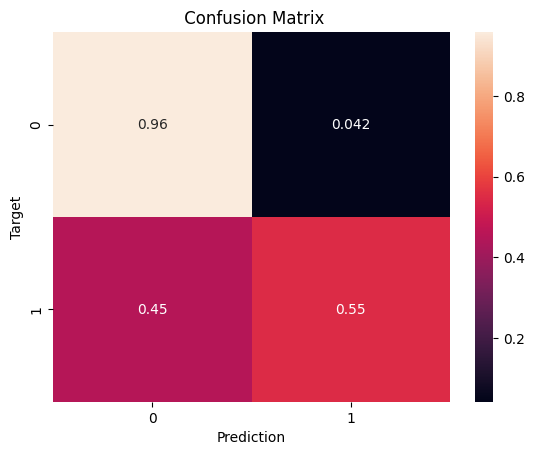

In [186]:
predict_and_plot(model, X_train, train_targets)

Accuracy: 86.97%


array([0., 0., 0., ..., 0., 0., 0.])

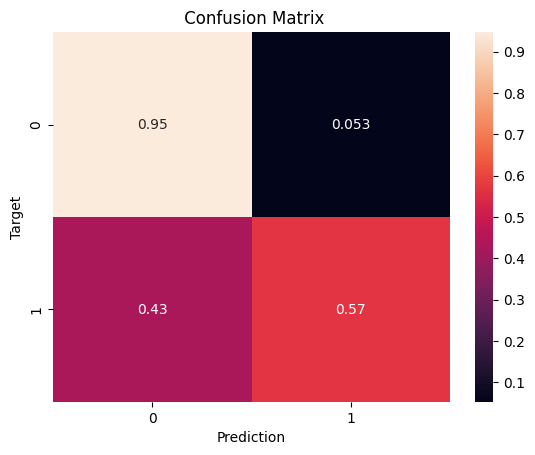

In [187]:
predict_and_plot(model, X_val, val_targets)


##### F1 score

In [188]:
def get_f1_score(model, inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds, pos_label=1.)
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(model, X_train, train_targets, 'Training')
get_f1_score(model, X_val, val_targets, 'Validation')

F1 score Training: 0.64%
F1 score Validation: 0.64%


##### ROC Curve & AUROC

In [189]:
def compute_auroc_and_build_roc(model, inputs, targets, name=''):
  
  y_pred_proba = model.predict_proba(inputs)[:, 1]
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1.)

  # AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()


AUROC for Training: 0.88


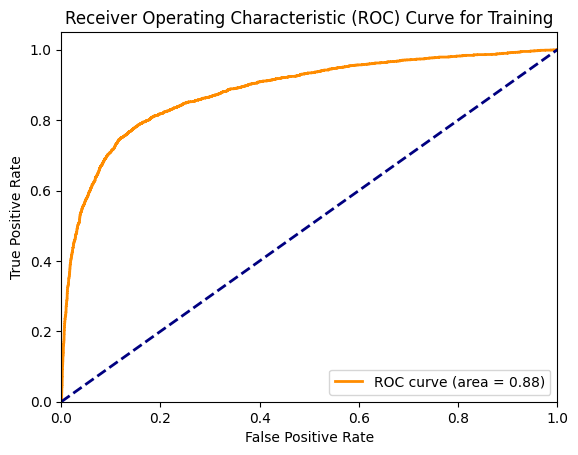

AUROC for Validation: 0.88


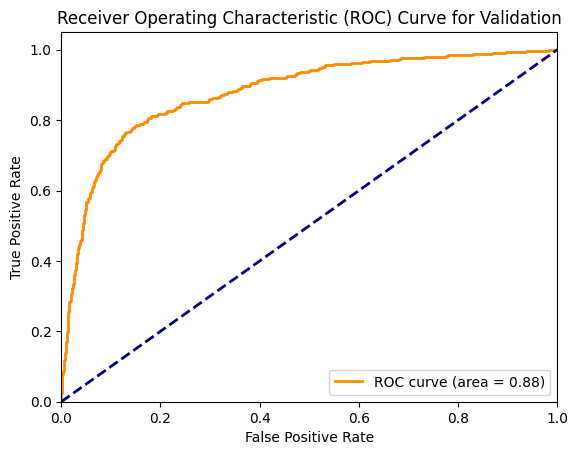

In [190]:
compute_auroc_and_build_roc(model, X_train, train_targets, 'Training')
compute_auroc_and_build_roc(model, X_val, val_targets, 'Validation')

Створена модель має значення:

* TP = 0.96
* TN = 0.54
* F1 score = 0.64%
* AUROC for Training: 0.88

для тренувальних даних, та:  


* TP = 0.95
* TN = 0.55
* F1 score = 0.63%
* AUROC for Validation: 0.88

для валідаційних.

ROC Curve знаходиться вище діагоналі для обох наборів даних.

З отриманих метрик якості можна сказати що модель дає задовіьлний результат як на тренувальному наборі, так і на нових для неї даних з валідаційного набору, проте в обох випадках не дуже добре розпізнає негативний клас

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [191]:
train_targets.value_counts()

Exited
0.0    9558
1.0    2442
Name: count, dtype: int64

In [192]:
val_targets.value_counts()


Exited
0.0    2390
1.0     610
Name: count, dtype: int64

В тренувальних даних переважає клас 0, створемо передбачення моделі яка для всіх екземплярів передбачатиме цей клас

In [193]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

train_maj = np.zeros(len(train_preds))
val_maj = np.zeros(len(val_preds))


val_preds, val_maj

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

Порахуємо accuracy для всіх передбачень

In [194]:
acc_val_maj = accuracy_score(val_targets, val_maj)
acc_train_maj = accuracy_score(train_targets, train_maj)

acc_val_pred = accuracy_score(val_targets, val_preds)
acc_train_pred = accuracy_score(train_targets, train_preds)

print(f'Аccuracy моделі з п.6 для тренувальних даних: {np.round(acc_train_pred, 3)}')
print(f'Аccuracy моделі з п.6 для валідаційних даних: {np.round(acc_val_pred, 3)}')
print(f'Аccuracy нової моделі для тренувальних даних: {np.round(acc_train_maj, 3)}')
print(f'Аccuracy нової моделі для валідаційних даних: {np.round(acc_val_maj, 3)}')


Аccuracy моделі з п.6 для тренувальних даних: 0.875
Аccuracy моделі з п.6 для валідаційних даних: 0.87
Аccuracy нової моделі для тренувальних даних: 0.796
Аccuracy нової моделі для валідаційних даних: 0.797


Точність передбачення завжди мажоритарним класом доволі висока, проте це зумовлено тим, що у даних значно більше об'єктів класу '0'.

Точнісь побудованої в п.6 моделі вища, отже якість моделі є задовільною

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [195]:
import joblib

In [196]:
log_reg = {
    'model': model,
    'scaler': scaler,
    'encoder': enc,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols,
    'cols_to_drop' : ['CustomerId', 'Gender_Female']
}

joblib.dump(log_reg, '../../models/logreg.joblib')

['../../models/aussie_rain.joblib']

In [197]:
log_reg2 = joblib.load('../../models/logreg.joblib')
log_reg2.keys()

dict_keys(['model', 'scaler', 'encoder', 'input_cols', 'target_col', 'numeric_cols', 'categorical_cols', 'encoded_cols', 'cols_to_drop'])

In [198]:
model_2 = log_reg2['model']
model_2

LogisticRegression(solver='liblinear')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [199]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, encoded_cols, input_df: pd.DataFrame):
    # Обробка числових колонок
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    # Обробка категоріальних колонок
    input_df[encoded_cols] = encoder.transform(input_df[['Geography', 'Gender']])

    X_input = input_df[numeric_cols + encoded_cols.tolist()]
    X_input = X_input.drop(['Gender_Female', 'CustomerId'], axis=1)

    prob = model.predict_proba(X_input)[:,1]
    return prob

In [200]:
# predict_input(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [201]:
test_raw_df = pd.read_csv(test_dir)

test_prob = predict_raw_df(scaler, enc, numeric_cols, categorical_cols, encoded_cols, test_raw_df)
test_prob

array([0.06939744, 0.03331558, 0.15358316, ..., 0.01659855, 0.15208852,
       0.08812064])

In [202]:
test_raw_df['Exited'] = test_prob
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,-0.654266,Chu,-1.034678,Germany,Male,-0.944682,-1.087792,1.720173,-1.108193,0.515062,1.016977,0.875226,0.0,1.0,0.0,0.0,1.0,0.069397
1,15001,-0.327399,Mazzi,-1.490909,France,Male,0.161227,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.109098,1.0,0.0,0.0,0.0,1.0,0.033316
2,15002,0.172605,Onyekachi,0.651991,France,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,-0.983306,0.850584,1.0,0.0,0.0,0.0,1.0,0.153583
3,15003,0.640831,Martin,0.804068,Spain,Male,0.898500,-0.728320,-0.717950,-1.108193,0.515062,1.016977,1.073044,0.0,0.0,1.0,0.0,1.0,0.199176
4,15004,-0.190363,Kenechukwu,-0.924077,Spain,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,1.016977,0.563521,0.0,0.0,1.0,0.0,1.0,0.054275


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [203]:
sample_submission_dir = '../../../data/bank-customer-churn-prediction-dlu/sample_submission.csv'
submission_log_reg = pd.read_csv(sample_submission_dir, index_col=0)
submission_log_reg['Exited'] = test_prob
submission_log_reg.head(10)

,Exited
id,
15000,0.069397
15001,0.033316
15002,0.153583
15003,0.199176
15004,0.054275
15005,0.167565
15006,0.137184
15007,0.121196
15008,0.036192


In [204]:
submission_log_reg.to_csv('../../../data/bank-customer-churn-prediction-dlu/submission_log_reg.csv')